<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/ContestTest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

In [29]:
# 1. 저장된 모델 불러오기
model = tf.keras.models.load_model('/content/drive/MyDrive/saveModel/bearing_fault_detection_model.h5', compile=False)

# 모델 재컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# 2. 평가용 데이터 불러오기 및 전처리

# 평가용 데이터 경로 설정 (예시 경로이므로 실제 경로로 수정 필요)
test_base_paths = ['/content/drive/MyDrive/bearing2']

# 데이터 로드 및 전처리 함수 (훈련 시 사용한 함수와 동일하게)
def load_data(base_paths):
    classes = ['normal', 'inner_fault', 'outer_fault', 'roller_fault']
    data = []
    labels = []
    for base_path in base_paths:
        for label, class_name in enumerate(classes):
            folder_path = os.path.join(base_path, class_name)
            if not os.path.exists(folder_path):
                continue  # 폴더가 없으면 넘어감
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if not file_path.endswith('.mat'):
                    continue  # .mat 파일이 아니면 넘어감
                mat_data = scipy.io.loadmat(file_path)
                signal = mat_data['signal'].flatten()  # 1차원 배열로 변환

                # 신호를 세그먼트로 분할 (각 세그먼트 길이: 1024 샘플)
                segment_length = 1024
                num_segments = len(signal) // segment_length
                for i in range(num_segments):
                    segment = signal[i * segment_length : (i + 1) * segment_length]
                    data.append(segment)
                    labels.append(label)

    # Numpy 배열로 변환
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# 테스트 데이터 로드
X_test, y_test = load_data(test_base_paths)

# 데이터 정규화 (훈련 데이터 전처리와 동일하게)
X_test = X_test / np.max(np.abs(X_test))

# 레이블 원-핫 인코딩
y_test = to_categorical(y_test, num_classes=4)

# 입력 데이터 형태 변경 (모델 입력에 맞게 reshaping)
X_test = X_test.reshape(-1, 1024, 1)

In [31]:
# 3. 모델 평가 (손실 및 정확도)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

968/968 - 13s - 14ms/step - accuracy: 0.9354 - loss: 0.5673
Test Loss: 0.5673
Test Accuracy: 0.9354


In [32]:
# 4. 예측 및 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측한 클래스
y_true = np.argmax(y_test, axis=1)          # 실제 클래스

968/968 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step


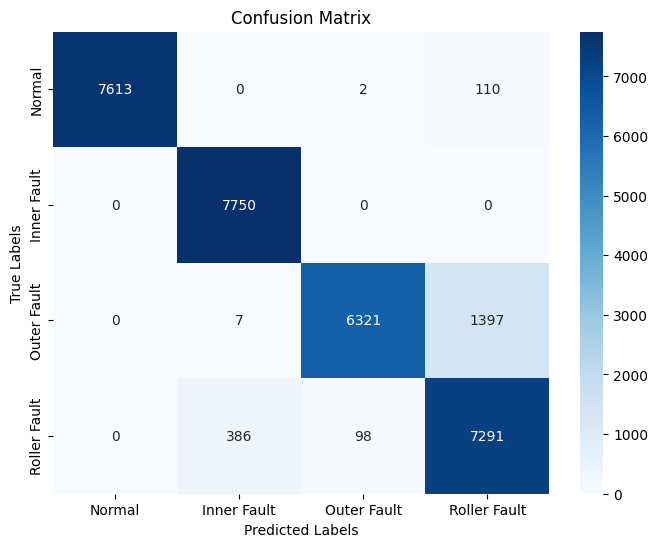

In [33]:
# 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'],
            yticklabels=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [34]:
# 분류 보고서 출력
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Inner Fault', 'Outer Fault', 'Roller Fault']))

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      7725
 Inner Fault       0.95      1.00      0.98      7750
 Outer Fault       0.98      0.82      0.89      7725
Roller Fault       0.83      0.94      0.88      7775

    accuracy                           0.94     30975
   macro avg       0.94      0.94      0.94     30975
weighted avg       0.94      0.94      0.94     30975



In [35]:
# F1 스코어 계산 및 출력
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

Macro F1 Score: 0.9354
Weighted F1 Score: 0.9353
